In [1]:
import numpy as np
import hist
import matplotlib.pyplot as plt
import mplhep as hep
import pickle
import lz4.frame
from wremnants import plot_tools, scetlib_corrections,theory_tools
from wremnants import boostHistHelpers as hh
from scipy import special
import uproot

Welcome to JupyROOT 6.27/01


In [3]:
%load_ext autoreload
%autoreload 2

In [2]:
with lz4.frame.open("/home/k/kelong/work/WRemnants/w_z_gen_dists.pkl.lz4") as minnlof:
    minnlo = pickle.load(minnlof)

In [4]:
minnlo.keys()

dict_keys(['WplusmunuPostVFP', 'WminusmunuPostVFP', 'WplustaunuPostVFP', 'WminustaunuPostVFP', 'ZmumuPostVFP', 'ZtautauPostVFP'])

In [4]:
minnlohZ = minnlo["ZmumuPostVFP"]["output"]["nominal_gen"]*2001/minnlo["ZmumuPostVFP"]["weight_sum"]
minnlohW = (minnlo["WplusmunuPostVFP"]["output"]["nominal_gen"]*minnlo["WplusmunuPostVFP"]["dataset"]["xsec"]+minnlo["WminusmunuPostVFP"]["output"]["nominal_gen"])*minnlo["WminusmunuPostVFP"]["dataset"]["xsec"]/(minnlo["WplusmunuPostVFP"]["weight_sum"]+minnlo["WminusmunuPostVFP"]["weight_sum"])


In [5]:
scetlibhZ_tot = scetlib_corrections.read_scetlib_hist("/home/k/kelong/work/Generators/scetlib-cms/prod/scetlib_run/helicityTest/Z/inclusive_Z.npz", add_nonsing=True, charge=0)
scetlibhZ_A4 = scetlib_corrections.read_scetlib_hist("/home/k/kelong/work/Generators/scetlib-cms/prod/scetlib_run/helicityTest/inclusive_Z_pT_A4.npz", add_nonsing=False, flip_y_sign=True, charge=0)

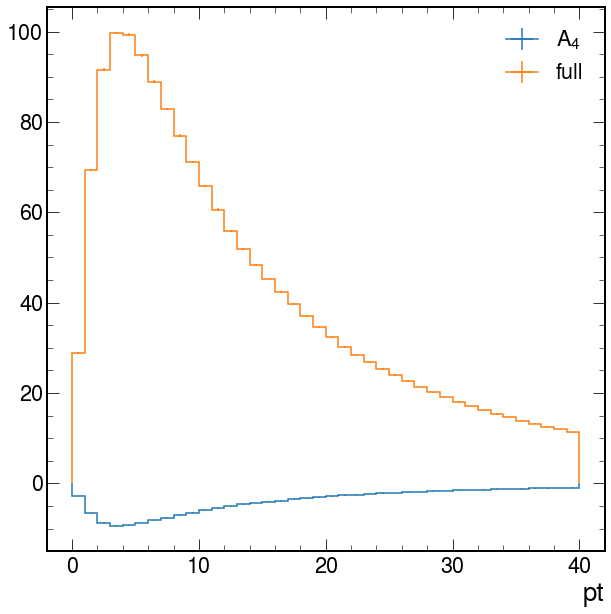

In [6]:
scetlibhZ_A4.project("pt").plot(label="A$_{4}$")
scetlibhZ_tot.project("pt").plot(label="full")
plt.legend()

In [ ]:
fig = plot_tools.makePlotWithRatioToRef([scetlibhZ_tot.project("y"), scetlibhZ_A4.project("y")], xlim=[-5, 5],colors=["red", "blue",], labels=["total", "A$_{4}$"], rrange=[-0.5, 0], binwnorm=1.)

In [ ]:
fig = plot_tools.makePlotWithRatioToRef([scetlibhZ_tot.project("pt"), scetlibhZ_A4.project("pt")],colors=["red", "blue",], labels=["total", "A$_{4}$"], rrange=[-0.1, 0], binwnorm=1.)

In [8]:
scetlibh = hh.makeAbsHist(scetlibhZ_tot, "y")

[StairsArtists(stairs=<matplotlib.patches.StepPatch object at 0x7f9e924ac700>, errorbar=<ErrorbarContainer object of 3 artists>, legend_artist=<ErrorbarContainer object of 3 artists>)]

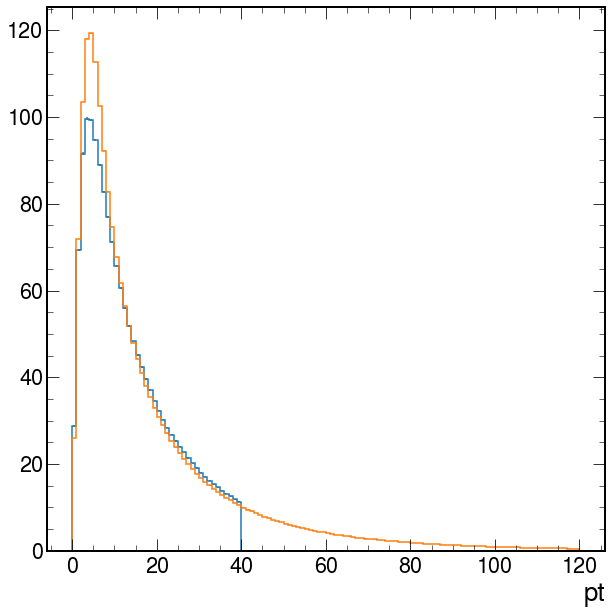

In [11]:
scetlibh.project("pt").plot()
minnlohZ.project("ptVgen").plot()

In [ ]:
ax = minnlohZ.axes[0]
edges = ax.edges[ax.index(scetlibh.axes[0].edges[0]):ax.index(scetlibh.axes[0].edges[-1])+1]

In [ ]:
all(x in edges for x in scetlibh.axes[0].edges)

In [ ]:
minnlohZ.axes.index(scetlibh.axes.edges)

In [ ]:
minnlohZ.axes[0].index(scetlibh.axes[0].edges)

In [ ]:
minnlohZ.axes[0].index(scetlibh.axes[0].edges)

In [15]:
minnlo_rebin = minnlohZ
for minnlo_ax, scetlib_ax in zip(minnlohZ.axes, scetlibh.axes[:-1]):
    minnlo_rebin = hh.rebinHist(minnlo_rebin, minnlo_ax.name, scetlib_ax.edges)

In [191]:
ratio2D = hh.divideHists(scetlibh.project("pt"), ratioh.project("pt"))

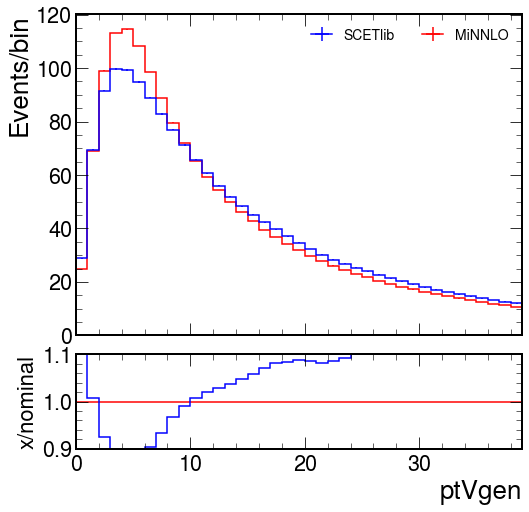

In [17]:
fig = plot_tools.makePlotWithRatioToRef([minnlo_rebin.project("ptVgen"), scetlibh.project("pt")],colors=["red", "blue",], labels=["MiNNLO", "SCETlib"], rrange=[0.9, 1.1], binwnorm=1.)

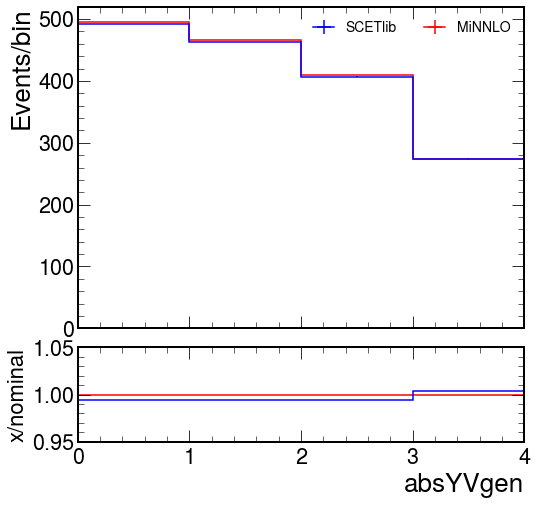

In [44]:
fig = plot_tools.makePlotWithRatioToRef([minnlo_rebin.project("absYVgen"), scetlibh.project("absy")],colors=["red", "blue",], labels=["MiNNLO", "SCETlib"], rrange=[0.95, 1.05], binwnorm=1.)


In [20]:
scetlibh.sum().value/minnlo_rebin.sum().value

0.9967050811198408

In [27]:
corrh = scetlib_corrections.make_scetlib_minnlo_corr(minnlohZ, scetlibh)

In [47]:
corrh

Hist(
  Variable([60, 120], name='mass', label='mass'),
  Variable([0, 1, 2, 3, 4, 5], name='absy', label='absy'),
  Variable(array([ 0.,  1.,  2.,  3.,  4.,  5.,  6.,  7.,  8.,  9., 10., 11., 12.,
       13., 14., 15., 16., 17., 18., 19., 20., 21., 22., 23., 24., 25.,
       26., 27., 28., 29., 30., 31., 32., 33., 34., 35., 36., 37., 38.,
       39., 40.]), name='pt', label='pt'),
  Regular(1, 0, 1, underflow=False, overflow=False, name='charge', label='charge'),
  Integer(0, 1, underflow=False, overflow=False, name='vars', label='vars'),
  storage=Weight()) # Sum: WeightedSum(value=208.711, variance=0.477121) (WeightedSum(value=890.711, variance=485.477) with flow)

In [42]:
corrh

Hist(
  Variable([60, 120], name='mass', label='mass'),
  Variable([0, 1, 2, 3, 4, 5], name='absy', label='absy'),
  Variable(array([ 0.,  1.,  2.,  3.,  4.,  5.,  6.,  7.,  8.,  9., 10., 11., 12.,
       13., 14., 15., 16., 17., 18., 19., 20., 21., 22., 23., 24., 25.,
       26., 27., 28., 29., 30., 31., 32., 33., 34., 35., 36., 37., 38.,
       39., 40.]), name='pt', label='pt'),
  Regular(1, 0, 1, underflow=False, overflow=False, name='charge', label='charge'),
  Integer(0, 1, underflow=False, overflow=False, name='vars', label='vars'),
  storage=Weight()) # Sum: WeightedSum(value=208.711, variance=0.477121) (WeightedSum(value=890.711, variance=485.477) with flow)

In [181]:
minnlohZ.values().take(indices=range(8), axis=0).shape

(8, 18, 120, 1)

In [178]:
minnlohZ.shape

(12, 18, 120, 1)

In [ ]:
hh.divideHists(h.project("ptVgen"), scetlibh.project("pt")).plot()

In [ ]:
scetlibh.axes

In [ ]:
minnlohZ.axes

In [ ]:
#ax = minnlohZ.axes["ptVgen"]
#np.add.reduceat(minnlohZ[0,0,:,0].values(), ax.index([0, 10, 20]))

In [ ]:
np.add.reduceat(minnlohZ[0,0,:,:].values(), ax.index(scetlibhZ_tot.axes["pt"].edges))

In [ ]:
axm = minnlohZsel.axes["massVgen"]
axy = minnlohZsel.axes["absYVgen"]
axpt = minnlohZsel.axes["ptVgen"]

In [ ]:
ipt = axpt.index(scetlibhZ_tot.axes["pt"].edges)
iy = axy.index(scetlibhZ_tot.axes["y"].edges)

In [ ]:
newh = np.add.reduceat(minnlohZ[:,:,:,0].values(), 
    ipt, axis=2
)

In [ ]:
newh = np.add.reduceat(newh, 
    (0,1), axis=1
)
np.sum(newh, axis=1, keepdims=True).shape

In [ ]:
# TODO: Make this nd
minnlocorr = minnlohZsel.project("ptVgen").copy()
scetlibcorr = minnlohZsel.project("ptVgen").copy()
max_pt_corr = scetlibcorr.axes["ptVgen"].index(scetlibhZ_tot.axes["pt"].edges[-1])
scetlibcorr[:max_pt_corr] = scetlibhZ_tot[0,0,...].project("pt").view()
corr = hh.divideHists(scetlibcorr, minnlocorr, cutoff=0.01)

In [ ]:
corr.plot()

In [ ]:
corr

In [ ]:
minnloScetlib = hh.multiplyHists(minnlohZsel, corr, transpose=False)

In [ ]:
minnloScetlib.project("ptVgen").plot()

In [ ]:
minnloScetlib.project("ptVgen").plot()
minnlohZsel.project("ptVgen").plot()
scetlibcorr.plot()

In [ ]:
fig = plot_tools.makePlotWithRatioToRef([pdfPtV[:,0], pdfUp, pdfDown], colors=["black", "red", "blue"], labels=["nominal", "up", "down"], rrange=[0.95, 1.05], binwnorm=1.)

In [ ]:
f = uproot.open("/eos/user/k/kelong/HistFiles/WGen/WmToMuNu_inclusive_MATRIX_RadISH_MatchEWParams_NNPDF31.root")
matrixRadish = f["wmmunu_matrix_radish/ptW_prefsr_mn"].to_hist()/1000

In [ ]:
scetlibh_tot = scetlib_corrections.readScetlibHist("/home/k/kelong/work/Generators/scetlib-cms/prod/scetlib_run/helicityTest/Wm/inclusive_Wm.npz", add_nonsing=True)
scetlibh_A4 = scetlib_corrections.readScetlibHist("/home/k/kelong/work/Generators/scetlib-cms/prod/scetlib_run/helicityTest/Wm/inclusive_Wm_A4.npz", add_nonsing=True, flip_y_sign=True)
scetlibh_tot_s = scetlib_corrections.readScetlibHist("/home/k/kelong/work/Generators/scetlib-cms/prod/scetlib_run/helicityTest/Wm/inclusive_Wm.npz", add_nonsing=False)

In [ ]:
minnlocorr = minnloh.project("ptVgen").copy()
scetlibcorr = minnloh.project("ptVgen").copy()
scetlibcorr[...,:40] = scetlibh_tot.project("pt").view()
corrW = hh.divideHists(scetlibcorr, minnlocorr, cutoff=0.01)

In [ ]:
corrW.shape

In [ ]:
corr[30.j:40.j].axes["ptVgen"].centers

In [ ]:
x = corr[20.j:40.j].axes["ptVgen"].centers
params = np.polyfit(y=corr[20.j:40.j].values(), x=x, deg = 2)
poly = np.poly1d(params)
xeval = corr[30.j:40.j].axes["ptVgen"].centers

In [ ]:
corr_orig = corr.copy()
corr[30:40] = np.stack((poly(xeval), corr[30.j:40.j].variances()), axis=-1)

In [ ]:
minnloScetlib = hh.multiplyHists(minnlocorr, corrW)
minnloScetlib.plot()
matrixRadish.plot()

In [ ]:
scetlibh_A4.project("y").plot(label=r"$\sigma_{4}$")
scetlibh_tot.project("y").plot(label=r"$\sigma_{\mathrm{UL}}$")
plt.legend()

In [ ]:
scetlib_A4_coeff = hh.divideHists(scetlibh_A4, scetlibh_tot, cutoff=0.0001)
scetlib_A4_coeff_pt = hh.divideHists(scetlibh_A4.project("pt"), scetlibh_tot.project("pt"), cutoff=0.0001)

In [ ]:
scetlib_A4_coeff_pt.plot()

In [ ]:
scetlibh_A4.project("y").values()

In [ ]:
scetlibh_A4_nons.project("y").plot(label="singular")
scetlibh_A4.project("y").plot(label="nonsingular")
plt.title("A$_{4}$")
plt.legend()

In [ ]:
minnloh

In [ ]:
scetlibh_const

In [ ]:
scetlibh_A0.project("pt").plot(label="A$_{0}$")
(0.1*scetlibh_tot.project("pt")).plot(label="total")
minnloh.project("ptVgen").plot(label="minnlo")
plt.legend()

In [ ]:
scetlibhZ = scetlib_corrections.readScetlibHist("/home/k/kelong/work/Generators/scetlib-cms/prod/scetlib_run/helicityTest/inclusive_Z_pT.npz")

In [ ]:
scetlibhZ.project("pt").plot()
minnlohZ.project("ptVgen").plot(binwnorm=1.)

In [ ]:
scetlibh.project("pt").plot(label="W")
(100*scetlibhZ).project("pt").plot(label="Z")
plt.legend()

In [ ]:
minnloh.project("ptVgen").plot(binwnorm=1., label="MiNNLO")
scetlibh.project("pt").plot(label="SCETlib")

In [ ]:
scetlibhWpt = scetlib_corrections.readScetlibHist("/home/k/kelong/work/Generators/scetlib-0.4-256-gbe3a9cb8/prod/scetlib_run/W/inclusive_Wm_pT.npz")

In [ ]:
scetlibhWpt[0,...].project("pt").plot(yerr=False)
minnloh.project("ptVgen").plot(binwnorm=1., label="MiNNLO")

In [ ]:
scetlibW_y_tot_s = scetlib_corrections.readScetlibHist("/home/k/kelong/work/Generators/scetlib-cms/prod/scetlib_run/helicityTest/Wm/inclusive_Wm_y_binMinnlo.npz")
scetlibW_y_tot_nons = scetlib_corrections.readScetlibHist("/home/k/kelong/work/Generators/scetlib-cms/prod/scetlib_run/helicityTest/Wm/inclusive_Wm_y_binMinnlo_nons.npz")
scetlibW_y_tot = scetlibW_y_tot_s + scetlibW_y_tot_nons

scetlibW_y_A4_s = scetlib_corrections.readScetlibHist("/home/k/kelong/work/Generators/scetlib-cms/prod/scetlib_run/helicityTest/Wm/inclusive_Wm_y_binMinnlo_A4.npz")
scetlibW_y_A4_nons = scetlib_corrections.readScetlibHist("/home/k/kelong/work/Generators/scetlib-cms/prod/scetlib_run/helicityTest/Wm/inclusive_Wm_y_binMinnlo_A4_nons.npz")
scetlibW_y_A4 = scetlibW_y_A4_s + scetlibW_y_A4_nons

#s = hist.tag.Slicer()
yax = scetlibW_y_A4.axes["y"]
scetlibW_y_A4[:,:,yax.index(0):,:] = scetlibW_y_A4[:,:,yax.index(0):,:].view()*-1

In [ ]:
scetlibW_y_tot = scetlib_corrections.readScetlibHist("/home/k/kelong/work/Generators/scetlib-cms/prod/scetlib_run/helicityTest/Wm/inclusive_Wm.npz", add_nonsing=True)

In [ ]:
scetlibW_yabs_A4 = makeYAbsHist(scetlibW_y_A4)
scetlibW_yabs_tot = makeYAbsHist(scetlibW_y_tot)

In [ ]:
yax = scetlibW_y_A4.axes["y"]
axs = scetlibW_y_A4.axes

In [ ]:
scetlib_absy_A4_coeff = hh.divideHists(scetlibW_yabs_A4.project("y"), scetlibW_yabs_tot.project("y"))

In [ ]:
scetlibW_yabs_A4.project("y").plot()
scetlibW_yabs_tot.project("y").plot()
plt.xlim([0, 4.0])

In [ ]:
hh.divideHists(scetlibW_yabs_A4.project("y"), scetlibW_yabs_tot.project("y")).plot()
plt.xlim([0,4.0])

In [ ]:
scetlibW_y_A4.project("y").plot(label="$\sigma_{4}$")
scetlibW_y_tot.project("y").plot(label="Total")
plt.legend()
plt.xlim([-4.5, 4.5])
plt.title("SCETlib structure functions")

In [ ]:
minnlohel = minnlo["WminusmunuPostVFP"]["output"]["helicity_moments_scale"][{"muRfact" : 1.j, "muFfact" : 1.j, "chargeVgen" : -1.j}]

In [ ]:
minnlohel[...,:30,4.j]

In [ ]:
minnloCoeffs = theory_tools.moments_to_angular_coeffs(minnlohel[...,:30:hist.sum,:].project("absYVgen", "helicity"))

In [ ]:
minnloCoeffs[{"helicity" : 4.j}]
#scetlib_absy_A4_coeff.plot()

In [ ]:
fig = plot_tools.makePlotWithRatioToRef([minnloCoeffs[{"helicity" : 4.j}], scetlib_absy_A4_coeff], colors=["red", "blue"], labels=["minnlo", "scetlib"], ylabel="A$_{4}$", rrange=[0.9, 1.1], rlabel="scetlib/minnlo")

In [ ]:
blah = np.expand_dims(blah, axis=tuple(range(blah.ndim, minnlohel.ndim-blah.ndim)))

In [ ]:
minnloByHel = minnlo["WminusmunuPostVFP"]["output"]["qcdScaleByHelicity"]*minnlo["WminusmunuPostVFP"]["dataset"]["xsec"]/minnlo["WminusmunuPostVFP"]["weight_sum"]
minnloByHel

In [ ]:
import uproot

In [ ]:
matrixRadish.plot()
minnloh.project("ptVgen").plot()

In [ ]:
f = uproot.open("/eos/user/k/kelong/HistFiles/ZGen/ZToMuMu_MATRIX_RadISH_MatchEWParams_NNPDF31.root")

In [ ]:
f["DYm50_matrix__radish/ptZ_lhe_mm"].to_hist().plot()
minnlohZ.project("ptVgen").plot()

In [ ]:
dyturbof = np.load("/eos/user/k/kelong/HistFiles/WGen/DYTurbo/wm-13tev-cms-n3ll.npz")

In [ ]:
ptax = hist.axis.Variable(dyturbof["bins"], name="pt")
dyturboh = hist.Hist(ptax, storage=hist.storage.Weight())
dyturboh[...] = np.stack((dyturbof["hist"], dyturbof["err"]), axis=-1)

In [ ]:
dyturboMatch = matrixRadish.copy()
dyturboMatch[:40] = dyturboh.view()/1000

In [ ]:
dyturboMatch

In [ ]:
scetlibMatch = matrixRadish.copy()
scetlibMatch[:40] = scetlibh_tot.project("pt").view()

In [ ]:
minnloZbug

In [ ]:
fig = plot_tools.makePlotWithRatioToRef([f["DYm50_matrix__radish/ptZ_lhe_mm"].to_hist(), minnlohZ.project("ptVgen")], colors=["blue", "green", ], labels=["MATRIX+RadISH (NNLO+N$^{3}$LL)", "MiNNLO (H$^{(2)}$ sign error)",], rrange=[0.9, 1.1], ylabel="$\sigma$/bin", xlabel="p$_{T}^{\mathrm{Z}}$ (GeV)", rlabel="x/NNLO+N$^{3}$LL", nlegcols=1)


In [ ]:
scetlibMatch.sum()

In [ ]:
minnlohW.sum()

In [ ]:
fig = plot_tools.makePlotWithRatioToRef([matrixRadish, minnloScetlib, minnlohW.project("ptVgen"), dyturboMatch, scetlibMatch],colors=["green", "orange", "blue", "red", "purple"], labels=["MATRIX+RadISH (NNLO+N$^{3}$LL)", "MiNNLO+SCETlib (NNLO+PS + N$^{3}$LL corr.)", "MiNNLO (NNLO+PS)", "DYTurbo (N$^{3}$LL)", "SCETlib (N$^{3}$LL)"], rrange=[0.9, 1.1], binwnorm=1., nlegcols=1, rlabel="x/Matrix+Rad", ylabel="$\sigma$/bin", xlabel="p$_{T}^{\mathrm{W}^{-}}$ (GeV)")

#fig = plot_tools.makePlotWithRatioToRef([matrixRadish, minnloh.project("ptVgen"), dyturboMatch, scetlibMatch],colors=["green", "blue", "red", "purple"], labels=["MATRIX+RadISH (NNLO+N$^{3}$LL)", "MiNNLO (NNLO+PS)", "DYTurbo (N$^{3}$LL)", "SCETlib (N$^{3}$LL)"], rrange=[0.9, 1.1], binwnorm=1., nlegcols=1, rlabel="x/Matrix+Rad", ylabel="$\sigma$/bin", xlabel="p$_{T}^{\mathrm{W}^{-}}$ (GeV)")



In [49]:
ls ..

combineResults/                  README.md           temp.txt
lowpu/                           ResultsOldSamples/  test/
mw_with_mu_eta_pt.pkl.lz4        scripts/            test.root
mz_wlike_with_mu_eta_pt.pkl.lz4  setup.sh            wremnants/
narf/                            temp/               w_z_gen_dists.pkl.lz4
notebooks/                       tempLowPU/
rdfCorrections/                  temp.py


In [188]:
with lz4.frame.open("../mz_wlike_with_mu_eta_pt.pkl.lz4") as f:
    out = pickle.load(f)

In [60]:
out["ZmumuPostVFP"]["output"]["nominal"]

Hist(
  Regular(48, -2.4, 2.4, name='eta', label='eta'),
  Regular(29, 26, 55, name='pt', label='pt'),
  Regular(2, -2, 2, underflow=False, overflow=False, name='charge', label='charge'),
  storage=Weight()) # Sum: WeightedSum(value=2.1768e+07, variance=2.14759e+07) (WeightedSum(value=2.41761e+07, variance=2.39617e+07) with flow)

In [189]:
out["ZmumuPostVFP"]["output"]["nominal_uncorr"].sum(flow=True).value/out["ZmumuPostVFP"]["output"]["nominal"].sum(flow=True).value

1.0089005148758106

In [96]:
old = out["ZmumuPostVFP"]["output"]["weight"]

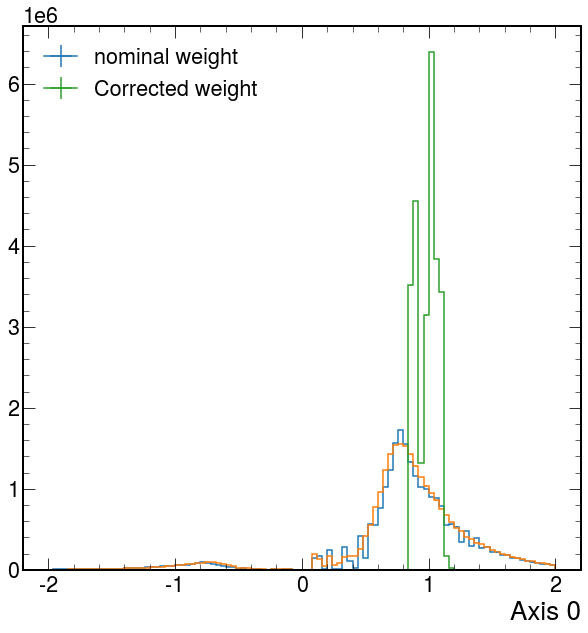

In [193]:
out["ZmumuPostVFP"]["output"]["weight_uncorr"].plot(label="nominal weight")
out["ZmumuPostVFP"]["output"]["weight"].plot()
old.plot(label="Corrected weight")
plt.legend()

In [ ]:
out["ZmumuPostVFP"]["output"]["weight"].plot()

[StairsArtists(stairs=<matplotlib.patches.StepPatch object at 0x7f9f5c8d5de0>, errorbar=<ErrorbarContainer object of 3 artists>, legend_artist=<ErrorbarContainer object of 3 artists>)]

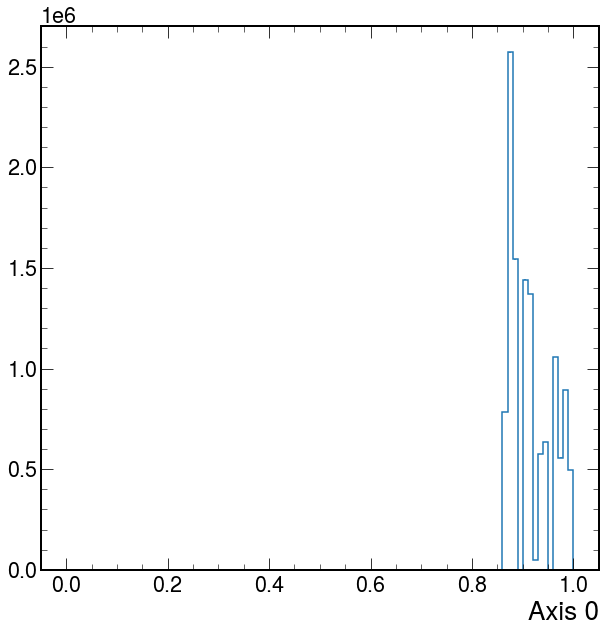

In [78]:
out["ZmumuPostVFP"]["output"]["corrWeight"].plot()

In [80]:
out["ZmumuPostVFP"]["output"].keys()

dict_keys(['dilepton', 'dilepton_uncorr', 'tensorSize', 'corrWeight', 'scetlibCorr', 'nominal', 'effStatTnP', 'effSystTnP', 'muonL1PrefireStat', 'muonL1PrefireSyst', 'nominal_uncorr', 'qcdScale', 'qcdScaleByHelicity', 'pdfNNPDF31', 'alphaS002pdfNNPDF31', 'massWeight', 'muonScaleSyst', 'muonScaleSyst_responseWeights'])

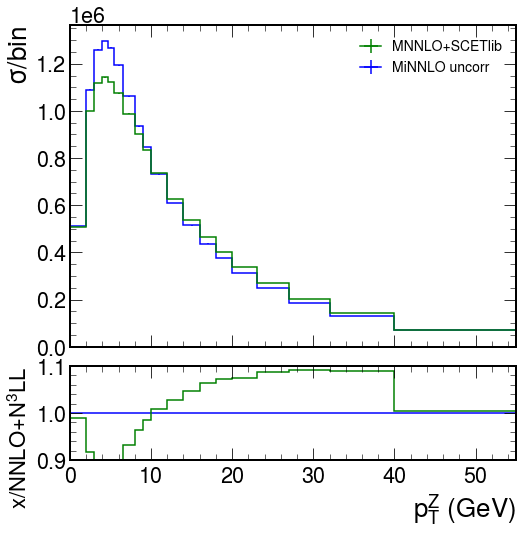

In [195]:
fig = plot_tools.makePlotWithRatioToRef([out["ZmumuPostVFP"]["output"]["dilepton_uncorr"].project("ptll"), out["ZmumuPostVFP"]["output"]["dilepton"].project("ptll"), ], colors=["blue", "green", ], labels=["MiNNLO uncorr", "MNNLO+SCETlib", ], rrange=[0.9, 1.1], ylabel="$\sigma$/bin", xlabel="p$_{T}^{\mathrm{Z}}$ (GeV)", rlabel="x/NNLO+N$^{3}$LL", nlegcols=1, binwnorm=True)

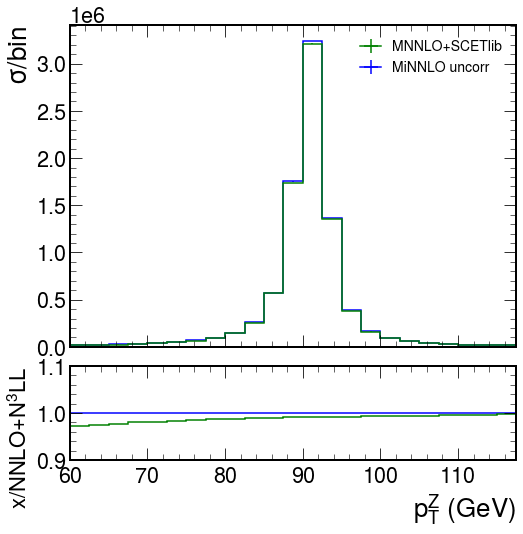

In [197]:
fig = plot_tools.makePlotWithRatioToRef([out["ZmumuPostVFP"]["output"]["dilepton_uncorr"].project("mll"), out["ZmumuPostVFP"]["output"]["dilepton"].project("mll"), ], colors=["blue", "green", ], labels=["MiNNLO uncorr", "MNNLO+SCETlib", ], rrange=[0.9, 1.1,], ylabel="$\sigma$/bin", xlabel="p$_{T}^{\mathrm{Z}}$ (GeV)", rlabel="x/NNLO+N$^{3}$LL", nlegcols=1, binwnorm=True)


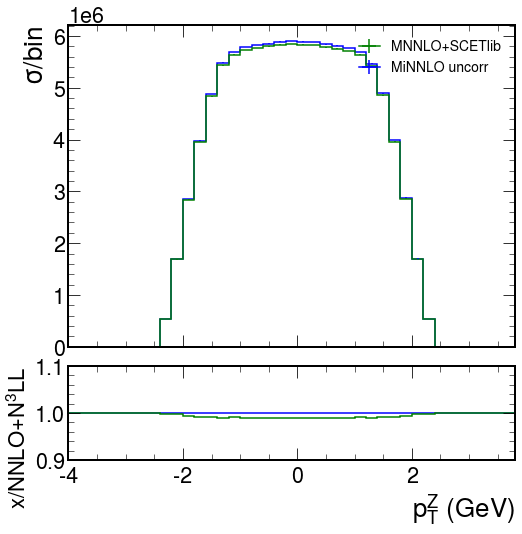

In [199]:
fig = plot_tools.makePlotWithRatioToRef([out["ZmumuPostVFP"]["output"]["dilepton_uncorr"].project("yll"), out["ZmumuPostVFP"]["output"]["dilepton"].project("yll"), ], colors=["blue", "green", ], labels=["MiNNLO uncorr", "MNNLO+SCETlib", ], rrange=[0.9, 1.1], ylabel="$\sigma$/bin", xlabel="p$_{T}^{\mathrm{Z}}$ (GeV)", rlabel="x/NNLO+N$^{3}$LL", nlegcols=1, binwnorm=True)

In [169]:
from wremnants import scetlib_corrections

In [172]:
corr = scetlib_corrections.make_corr_helper(isW=False)

Shape is (1, 5, 40, 1, 1)
